# Demo stixpy analysis notebook for the DynaSun Workshop
*written by Hannah Collier, Sep 2024*


## Import the required packages

In [91]:
from sunpy.net import Fido, attrs as a
from stixpy.net.client import STIXClient  # Registers the STIXClient with Fido
from stixpy.product import Product
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sunpy.timeseries import TimeSeries
from stixpy import timeseries # Registers the STIX timeseries with TimeSeries
from sunpy.time import parse_time
from astropy.coordinates import SkyCoord
from sunpy.map import Map
import astropy.units as u
import numpy as np
import pandas as pd

## Reading in the [STIX flarelist](https://github.com/hayesla/stix_flarelist_science)

In [93]:
stx_flarelist = pd.read_csv('STIX_flarelist_w_locations_20210318_20240801_version1_pythom.csv', index_col=0)

In [96]:
stx_flarelist.head()

,end_UTC,peak_UTC,4-10 keV,10-15 keV,15-25 keV,25-50 keV,50-84 keV,att_in,bkg 4-10 keV,bkg 10-15 keV,...,hgs_lat,hgc_lon,hgc_lat,solo_position_lat,solo_position_lon,solo_position_AU_distance,GOES_class_time_of_flare,GOES_flux_time_of_flare,flare_id,sidelobes_ratio
start_UTC,,,,,,,,,,,,,,,,,,,,,
2021-03-18T14:51:39.337,2021-03-18T14:58:55.337,2021-03-18T14:53:07.337,5375,335,99,927,543,False,271.0,53.0,...,20.339668,244.371990,20.339668,1.601911,-110.598275,0.666330,A,3.488101e-08,2103181453,0.766586
2021-03-19T14:01:39.177,2021-03-19T14:21:03.183,2021-03-19T14:05:31.178,1215,99,91,927,543,False,271.0,53.0,...,20.822767,222.118021,20.822767,1.565540,-109.851528,0.672826,A,3.917223e-08,2103191405,0.754688
2021-03-19T18:34:35.205,2021-03-19T18:53:51.109,2021-03-19T18:42:43.108,2687,183,99,927,543,False,271.0,53.0,...,20.755609,222.854340,20.755609,1.558217,-109.706731,0.674117,A,4.179104e-08,2103191842,0.760059
2021-03-20T09:04:39.093,2021-03-20T09:12:19.094,2021-03-20T09:06:39.093,1087,123,91,927,543,False,271.0,49.0,...,20.222089,224.407464,20.222089,1.535231,-109.263524,0.678135,A,4.073035e-08,2103200906,0.770594
2021-03-20T12:03:31.111,2021-03-20T12:29:11.114,2021-03-20T12:14:59.112,1727,151,91,927,543,False,271.0,49.0,...,20.546974,221.863290,20.546974,1.530189,-109.168512,0.679010,A,5.101582e-08,2103201214,0.766514


In [97]:
stx_flarelist.columns

Index(['end_UTC', 'peak_UTC', '4-10 keV', '10-15 keV', '15-25 keV',
       '25-50 keV', '50-84 keV', 'att_in', 'bkg 4-10 keV', 'bkg 10-15 keV',
       'bkg 15-25 keV', 'bkg 25-50 keV', 'bkg 50-84 keV',
       'bkg_baseline_4-10 keV', 'hpc_x_solo', 'hpc_y_solo', 'hpc_x_earth',
       'hpc_y_earth', 'visible_from_earth', 'hgs_lon', 'hgs_lat', 'hgc_lon',
       'hgc_lat', 'solo_position_lat', 'solo_position_lon',
       'solo_position_AU_distance', 'GOES_class_time_of_flare',
       'GOES_flux_time_of_flare', 'flare_id', 'sidelobes_ratio'],
      dtype='object')

## Downloading Data with Fido

In [2]:
query = Fido.search(a.Instrument.stix, a.Time('2024-03-10 11:45', '2024-03-10 12:30'))

In [3]:
query

Start Time,End Time,Instrument,Level,DataType,DataProduct,Ver,Request ID
object,object,str4,str2,str3,str20,str4,str21
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-lightcurve,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-background,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-variance,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-spectra,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-flareflag,V02,-
2024-03-10 00:00:00.000,2024-03-10 23:59:59.999,STIX,L1,QL,ql-tmstatusflarelist,V02,-
2024-03-10 11:56:26.000,2024-03-10 12:45:18.000,STIX,L1,SCI,sci-xray-cpd,V02,2403102193
2024-03-10 11:59:06.000,2024-03-10 12:15:40.000,STIX,L1,SCI,sci-xray-cpd,V02,2403109216
2024-03-10 07:35:05.000,2024-03-10 13:40:08.000,STIX,L1,SCI,sci-xray-spec,V02,2403103995


In [4]:
res_ql = Fido.fetch(query[0][0])
res_cpd = Fido.fetch(query[0][7])
res_spec = Fido.fetch(query[0][-4])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Exception ignored in: <function BaseEventLoop.__del__ at 0x10cc23ec0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/asyncio/base_events.py", line 728, in __del__
    self.close()
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/asyncio/unix_events.py", line 71, in close
    self.remove_signal_handler(sig)
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/asyncio/unix_events.py", line 160, in remove_signal_handler
    signal.signal(sig, handler)
  File "/opt/anaconda3/envs/dynasun/lib/python3.12/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: signal only works in main thread of the main interpreter


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Quicklook Data

In [5]:
ql_lc = TimeSeries(res_ql)

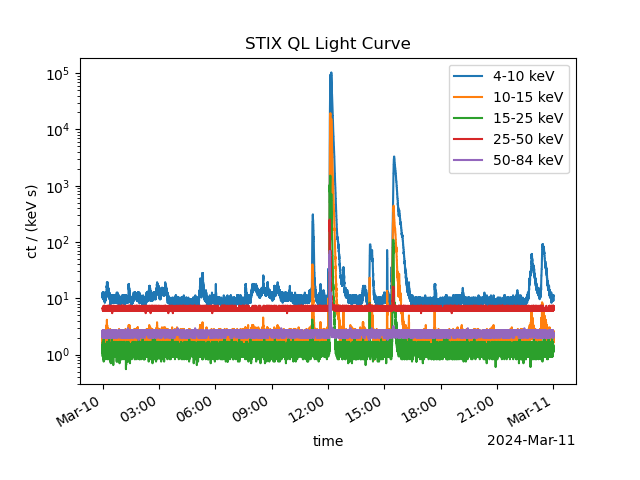

In [7]:
%matplotlib widget
ql_lc.peek()


## Spectrogram Data

In [8]:
spec = Product(res_spec)

(np.float64(19792.493055555555), np.float64(19792.534722222223))

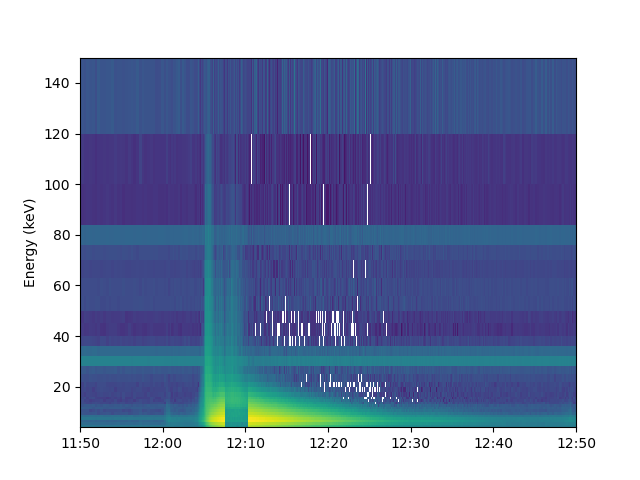

In [9]:
fig,ax=plt.subplots()
spec.plot_spectrogram(axes=ax)
ax.set_ylabel('Energy (keV)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlim([parse_time('2024-03-10 11:50').to_datetime(),parse_time('2024-03-10 12:50').to_datetime()] )

## Compressed Pixel Data

In [10]:
cpd = Product(res_cpd)

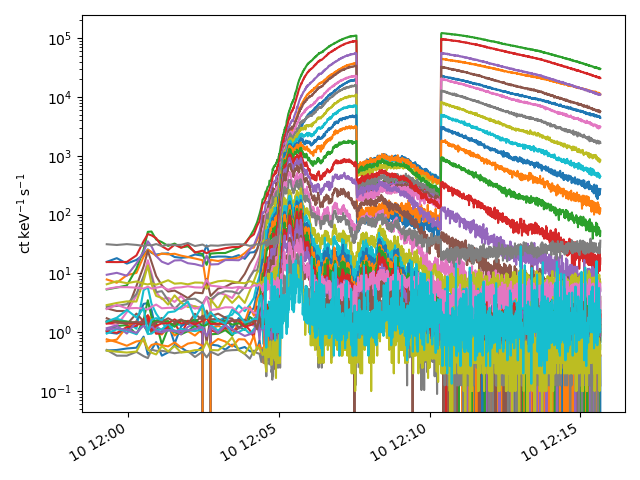

In [11]:
cpd.plot_timeseries()

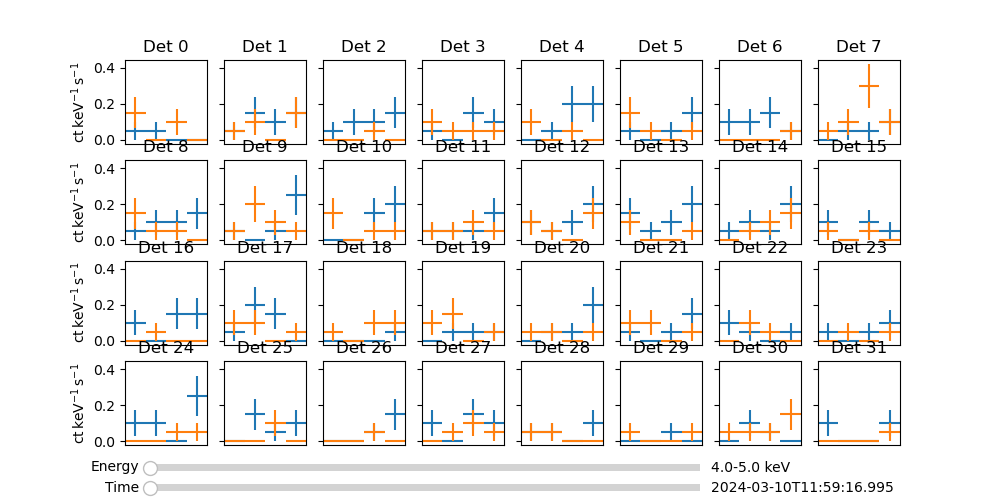

In [12]:
cpd.plot_pixels()

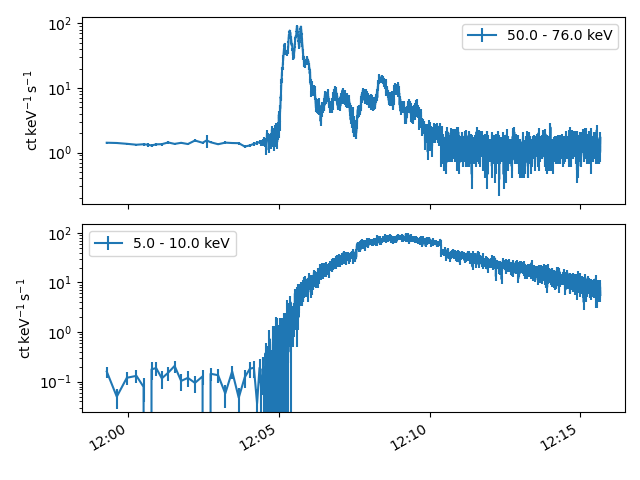

In [14]:
fig,ax=plt.subplots(2,1, sharex=True)
cpd.plot_timeseries(axes=ax[0], energy_indices = [[22,25]], error_bar=True)
ax[0].legend()
cpd.plot_timeseries(axes=ax[1], energy_indices = [[1,5]], detector_indices = [9], pixel_indices = [[2,5]], error_bar=True)
ax[1].legend()
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


In [15]:
counts, errors, times, deltatimes, energies = cpd.get_data(energy_indices=[[22,25]])

In [16]:
counts.to(u.ct/u.s/u.keV)

<Quantity [[[[0.00769231],
             [0.00576923],
             [0.00769231],
             ...,
             [0.00384615],
             [0.00384615],
             [0.00769231]],

            [[0.00384615],
             [0.00769231],
             [0.00576923],
             ...,
             [0.00192308],
             [0.00576923],
             [0.00576923]],

            [[0.00961538],
             [0.00576923],
             [0.        ],
             ...,
             [0.00384615],
             [0.00384615],
             [0.00192308]],

            ...,

            [[0.00576923],
             [0.00384615],
             [0.00961538],
             ...,
             [0.00576923],
             [0.00384615],
             [0.00576923]],

            [[0.00769231],
             [0.00769231],
             [0.00769231],
             ...,
             [0.00384615],
             [0.00576923],
             [0.00769231]],

            [[0.00769231],
             [0.00576923],
             [0.  

## Quicklook Imaging

In [17]:
stx_clean_maps = Map('stix_L3A_quicklook_20240310T120507-20240310T120536-32.0-84.0keV_2403109216_248_user_clean_hpc.fits')

In [18]:
parse_time(stx_clean_maps[4].meta['date-avg']) + cpd.meta['EAR_TDEL']*u.s

<Time object: scale='utc' format='isot' value=2024-03-10T12:08:58.037>

In [19]:
aia_query = Fido.search(a.Instrument.aia, a.Time('2024-03-10 12:08:58','2024-03-10 12:09:58'), a.Wavelength(1600*u.Angstrom))

In [20]:
aia_query

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2024-03-10 12:09:02.000,2024-03-10 12:09:03.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2024-03-10 12:09:26.000,2024-03-10 12:09:27.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2024-03-10 12:09:50.000,2024-03-10 12:09:51.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


In [21]:
aia_res = Fido.fetch(aia_query[0][0])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [22]:
aia_map = Map(aia_res)

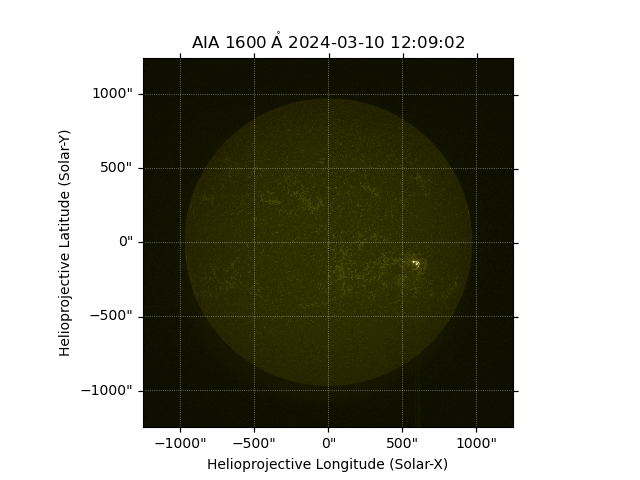

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection = aia_map.wcs)
aia_map.plot(axes=ax)

In [24]:
bl = SkyCoord(400*u.arcsec, -300*u.arcsec, frame = aia_map.coordinate_frame)
tr = SkyCoord(800*u.arcsec, 0*u.arcsec, frame = aia_map.coordinate_frame)

In [25]:
aia_submap = aia_map.submap(bottom_left=bl, top_right=tr)

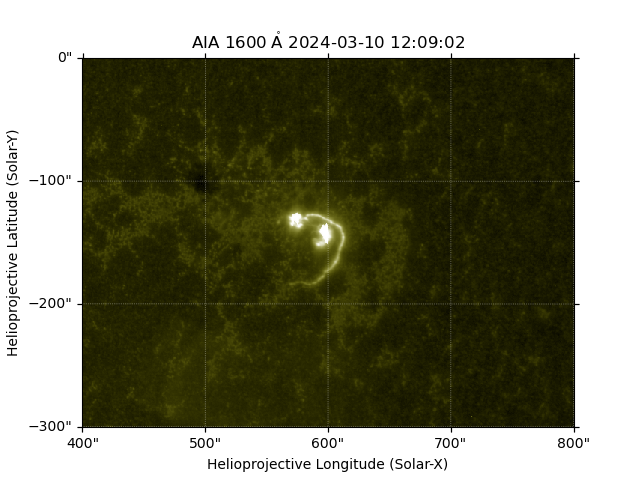

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection = aia_submap.wcs)
aia_submap.plot()

In [27]:
stx_clean_maps[4].meta['rsun_ref'] = aia_submap.meta['rsun_ref']

In [28]:
reprojected_stx_map = stx_clean_maps[4].reproject_to(aia_submap.wcs)

2024-09-04 00:13:38 - reproject.common - INFO: Calling _reproject_full in non-dask mode


Text(0.5, 1.0, '2024-03-10T12:05:22.095')

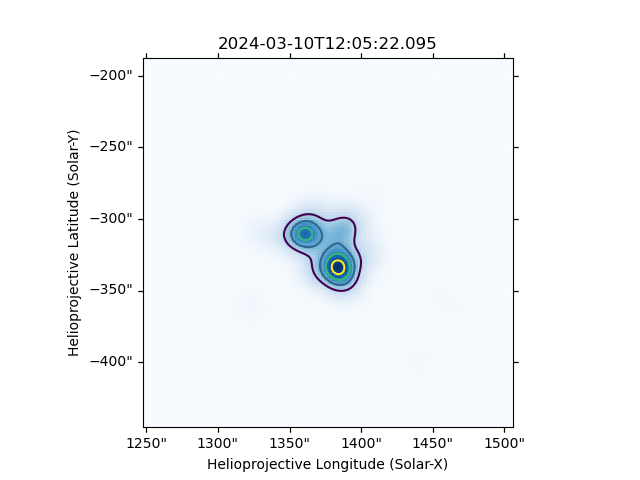

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection = stx_clean_maps[4].wcs)
stx_clean_maps[4].plot(cmap='Blues')
stx_clean_maps[4].draw_contours(np.arange(30,100,20)*u.percent)
ax.set_title(f'{stx_clean_maps[4].meta['date-avg']}')

Text(0.5, 1.0, '2024-03-10T12:09:03.580')

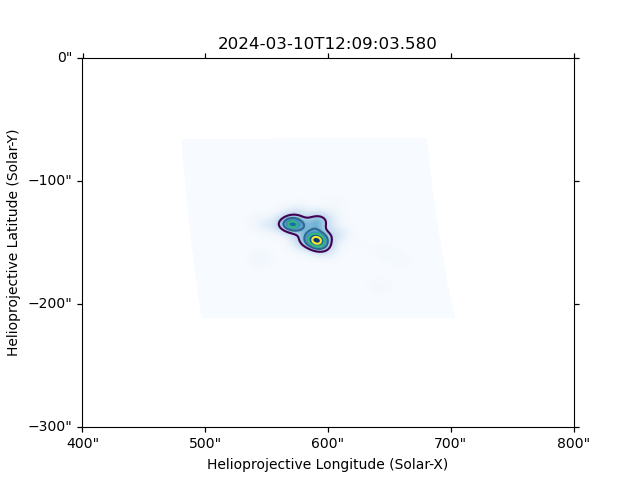

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection = reprojected_stx_map.wcs)
reprojected_stx_map.plot(cmap='Blues')
reprojected_stx_map.draw_contours(np.arange(30,100,20)*u.percent)
ax.set_title(f'{reprojected_stx_map.meta['date-avg']}')

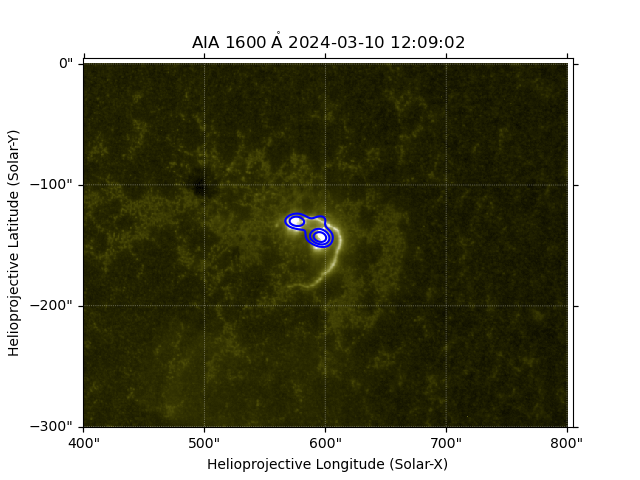

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection = aia_submap.wcs)
aia_submap.plot()
reprojected_stx_map.shift_reference_coord(5*u.arcsec, 5*u.arcsec).draw_contours(np.arange(40,100,20)*u.percent, colors='blue')
# ax.set_title(f'{reprojected_stx_map.meta['date-avg']}')

## Now let's look at a fun example with thermal HXR QPPs!

In [39]:
query_th_qpp = Fido.search(a.Instrument.stix, a.Time('2022-08-29 16:00', '2022-08-29 17:30'), a.stix.DataType.sci)

In [40]:
res_th_qpp = Fido.fetch(query_th_qpp[0][2])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [41]:
cpd_th_qpp = Product(res_th_qpp)

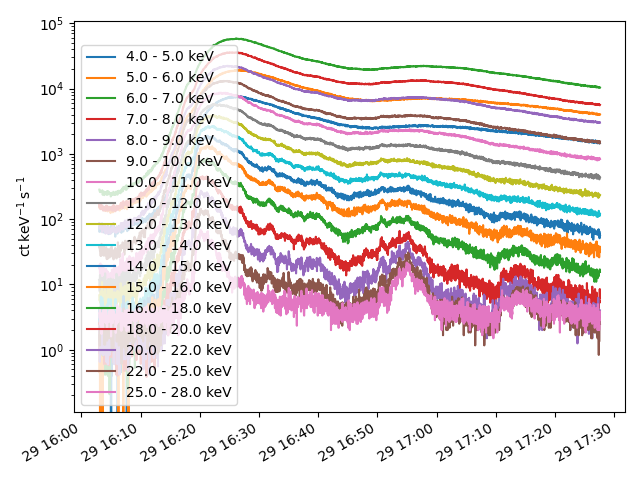

In [43]:
cpd_th_qpp.plot_timeseries()
plt.legend()

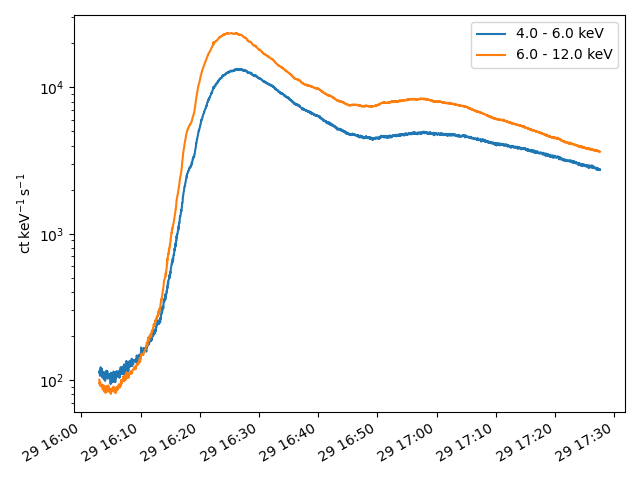

In [42]:
cpd_th_qpp.plot_timeseries(energy_indices = [[0,1],[2,7]])
plt.legend()

In [44]:
counts_th_qpps, errors_th_qpps, times_th_qpps, deltatimes_th_qpps, energies_th_qpps = cpd_th_qpp.get_data(detector_indices = [[0,31]], pixel_indices = [[0,12]], energy_indices = [[0,1],[2,7]])

In [46]:
counts_4_6 = counts_th_qpps.to(u.ct/u.s/u.keV)[:,:,:,0].reshape(-1).value
counts_6_12 = counts_th_qpps.to(u.ct/u.s/u.keV)[:,:,:,1].reshape(-1).value

In [47]:
from scipy.signal import savgol_filter

In [48]:
smoothed_profile_4_6 = savgol_filter(counts_4_6, window_length=60, polyorder=3)
smoothed_profile_6_12 = savgol_filter(counts_6_12, window_length=60, polyorder=3)

/var/folders/l6/88j7fvx51715f93rw6wngs_m0000gn/T/ipykernel_31643/2722986428.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


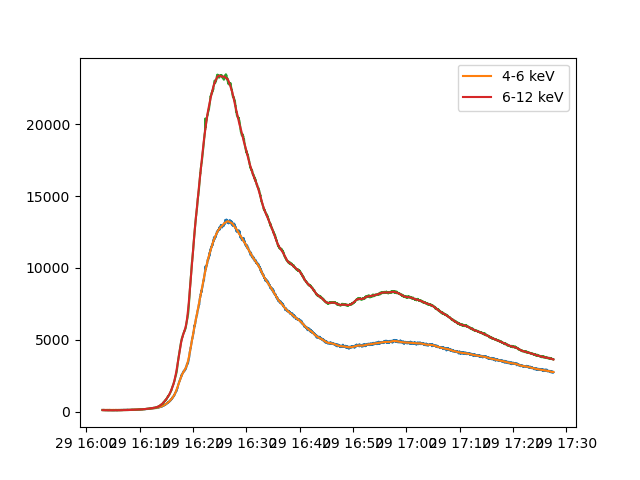

In [56]:
fig,ax=plt.subplots()
ax.plot(times_th_qpps.datetime, counts_4_6)
ax.plot(times_th_qpps.datetime,smoothed_profile_4_6, label='4-6 keV')

ax.plot(times_th_qpps.datetime, counts_6_12)
ax.plot(times_th_qpps.datetime,smoothed_profile_6_12, label='6-12 keV')
ax.legend()

In [ ]:
# detrended_counts_4_6 = counts_4_6 - smoothed_profile_4_6
# detrended_counts_6_12 = counts_6_12 - smoothed_profile_6_12

# smoothed_detrended_4_6 = savgol_filter(detrended_counts_4_6,window_length=20, polyorder=3)
# smoothed_detrended_6_12 = savgol_filter(detrended_counts_6_12,window_length=20, polyorder=3)

In [ ]:
deriv_4_6 = np.gradient(counts_4_6)
deriv_6_12 = np.gradient(counts_6_12)

smooth_deriv_4_6 = savgol_filter(deriv_4_6, window_length=20, polyorder=3)
smooth_deriv_6_12 = savgol_filter(deriv_6_12, window_length=20, polyorder=3)

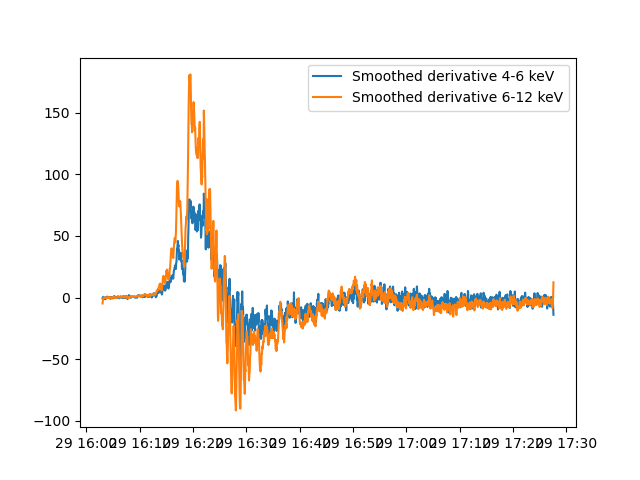

In [62]:
fig,ax=plt.subplots()
ax.plot(times_th_qpps.datetime, smooth_deriv_4_6, label='Smoothed derivative 4-6 keV')
ax.plot(times_th_qpps.datetime, smooth_deriv_6_12, label='Smoothed derivative 6-12 keV')
ax.legend()

### Let's compare with GOES data...

In [63]:
query_th_qpp_goes = Fido.search(a.Instrument.goes,  a.Time('2022-08-29 16:00', '2022-08-29 17:30'))

In [64]:
goes_res = Fido.fetch(query_th_qpp_goes[0][0] )

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [65]:
goes_ts = TimeSeries(goes_res)

<Axes: ylabel='Watts m$^{-2}$'>

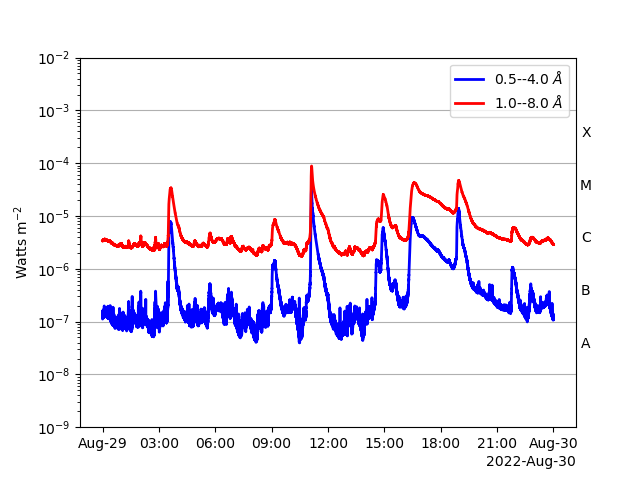

In [66]:
fig,ax=plt.subplots()
goes_ts.plot(axes=ax)

In [ ]:
df_goes = goes_ts.to_dataframe()

df_goes_truncated = df_goes.truncate(before = parse_time('2022-08-29 16:10').to_datetime(), after = parse_time('2022-08-29 17:00').to_datetime())

In [69]:
goes_time = df_goes_truncated.index
goes_deriv = np.gradient(df_goes_truncated['xrsa'])
goes_deriv_smoothed = savgol_filter(goes_deriv, window_length = 30, polyorder=3)

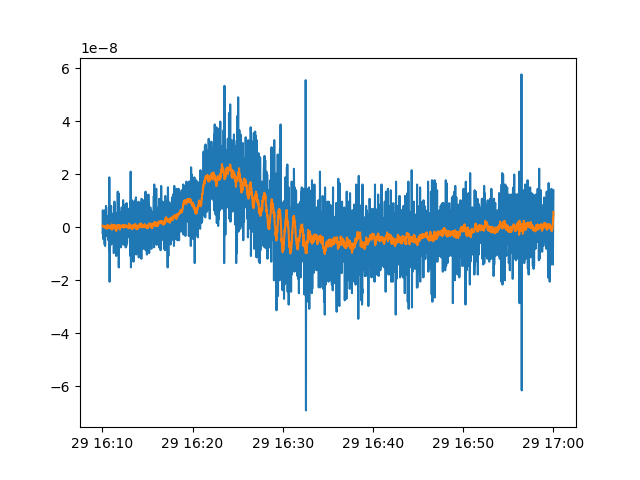

In [70]:
fig,ax=plt.subplots()
ax.plot(goes_time, goes_deriv)
ax.plot(goes_time, goes_deriv_smoothed)

In [71]:
from astropy.time import Time

Text(0.5, 141.47286656924004, '2022-08-29')

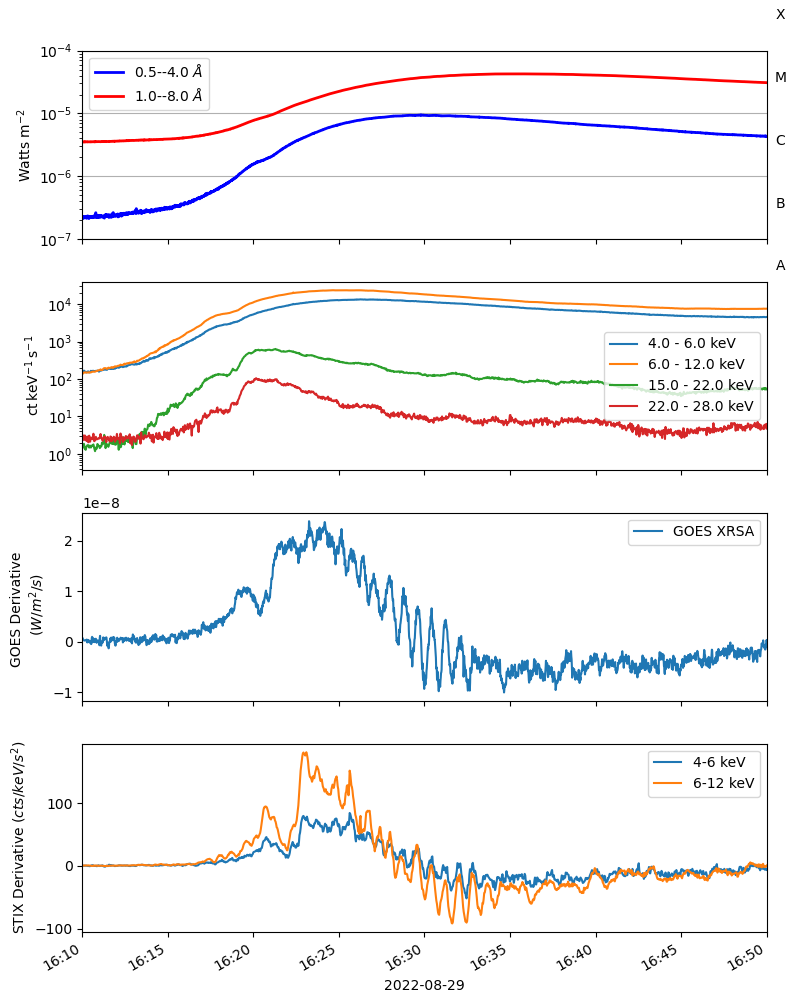

In [90]:
fig,ax=plt.subplots(4,1, sharex=True, figsize=[8,10])
goes_ts.plot(axes=ax[0])
ax[0].set_ylim([10**(-7), 10**(-4)])

cpd_th_qpp.plot_timeseries(axes=ax[1], energy_indices=[[0,1],[2,7], [11,14], [15,16]])
ax[1].legend()

ax[2].plot(goes_time, goes_deriv_smoothed, label='GOES XRSA')
ax[2].set_ylabel('GOES Derivative \n ($W/m^2/s$)')
ax[2].legend()

ax[3].plot((Time(times_th_qpps.datetime) + cpd.meta['EAR_TDEL']*u.s).datetime, smooth_deriv_4_6, label='4-6 keV')
ax[3].plot((Time(times_th_qpps.datetime) + cpd.meta['EAR_TDEL']*u.s).datetime, smooth_deriv_6_12, label='6-12 keV')
ax[3].set_xlim([parse_time('2022-08-29 16:10').datetime, parse_time('2022-08-29 16:50').datetime])
ax[3].set_ylabel('STIX Derivative ($cts/keV/s^2$)')
ax[3].legend()
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[3].set_xlabel('2022-08-29')